## ARIMA/SARIMA

6. **[Part 6: Model Build and Performance](#part6)**
- **Objective**: Build multiple types of models and assess performance
- **Tasks:**
  - Model build
  - Validation prediction
  - Performance assessment

In [ ]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from statsmodels.tsa.deterministic import DeterministicProcess
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import Fourier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from xgboost import XGBRegressor
# import mlflow
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

XSMALL_SIZE = 8
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=XSMALL_SIZE)           # controls default text sizes\\n\",\n",
plt.rc('axes', titlesize=XSMALL_SIZE)     # fontsize of the axes title\\n\",\n",
plt.rc('axes', labelsize=XSMALL_SIZE)    # fontsize of the x and y labels\\n\",\n",
plt.rc('xtick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('ytick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('legend', fontsize=XSMALL_SIZE)    # legend fontsize\\n\",\n",
plt.rc('figure', titlesize=XSMALL_SIZE)  # fontsize of the figure title\\n\",\n",
plt.rc('figure', figsize=(7, 2))
plt.rc('figure', dpi=200)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

#paths
path_in_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/inputs/'
path_out_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/outputs/'

#global variables
TARGET = 'orders'

## ARIMA/SARIMA

Based on performed tests, we would choose the following orders for ARIMA/SARIMA (p, d, q)(P, D, Q, m):

+ based on autocorrelation orders: non-sesonal p = 2, seasonal P = 2
+ based on partial autocorrelation orders: non-seasonal q = 3, seasonal Q = 1
+ based on trend exploratory analysis: d = 0
+ we chose seasonal period of 168 (24*7) for test and seasonalal period of 336 for validation

Note, that due to the limited computing capacity, we could run SARIMA in one notebook only once and only with the following orders: (1, 0, 1)(1, 0, 1, 168) for test.

As expected, ARIMA model, which doesn't capture seasonality of any sort performes poorly and predicts just mean orders. On the contrary, SARIMA model performs relatively well and we were able to get predictions with MSE of 913 and R^2 of 95%.

- Ensure, all datasets are properly indexed

In [46]:
df_orders = pd.read_csv(path_in_ + 'data_BCN.csv', dtype = str)
df = df_orders.copy()

df['orders'] = df['orders'].astype(float)

In [47]:
train_df = df.iloc[:-504]
val_df = df.iloc[-504:-168]
test_df = df.iloc[-168:]

# Display the shapes to verify the splits
print(f'Train set size: {train_df.shape}')
print(f'Validation set size: {val_df.shape}')
print(f'Test set size: {test_df.shape}')

Train set size: (8262, 3)
Validation set size: (336, 3)
Test set size: (168, 3)


In [48]:
train_df.set_index('time', inplace=True)
train_df.index = pd.to_datetime(train_df.index)  # Ensure index is in datetime format
train_df.index.min(), train_df.index.max()

(Timestamp('2021-02-01 00:00:00'), Timestamp('2022-01-11 23:00:00'))

In [49]:
val_df.set_index('time', inplace=True)
val_df.index = pd.to_datetime(val_df.index)  # Ensure index is in datetime format
val_df.index.min(), val_df.index.max()


(Timestamp('2022-01-12 00:00:00'), Timestamp('2022-01-25 23:00:00'))

In [50]:
test_df.set_index('time', inplace=True)
test_df.index = pd.to_datetime(test_df.index)  # Ensure index is in datetime format
test_df.index.min(), test_df.index.max()

(Timestamp('2022-01-26 00:00:00'), Timestamp('2022-02-01 23:00:00'))

- Account for the cycle in August by imputing hourly data in August with the hourly mean values calculated from all the months in the training data.

In [51]:
train_df['month'] = train_df.index.month
train_df['hour'] = train_df.index.hour
# Calculate the mean of 'orders_winsorized' for every hour, excluding data for month=8
mean_hourly_data = train_df[train_df['month'] != 8].groupby('hour')['orders'].mean()

# Replace hourly data for month=8 with mean hourly values
train_df.loc[train_df['month'] == 8, 'orders'] = train_df[train_df['month'] == 8].apply(
    lambda row: mean_hourly_data[row['hour']], axis=1
)

# Add back the rows with month=8 to the DataFrame
train_df = pd.concat([train_df[train_df['month'] != 8], train_df[train_df['month'] == 8]])

# Sort the DataFrame back to its original order
train_df = train_df.sort_index()

C:\Users\Asus\AppData\Local\Temp\ipykernel_25544\3188182007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['month'] = train_df.index.month
C:\Users\Asus\AppData\Local\Temp\ipykernel_25544\3188182007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df.index.hour


- log transform target - we tried log transformation of the target variable, but it led to the worse performance of the model.

In [52]:
# # Define the function to add one and apply log transform to 'orders' column
# def log_transform(df, column='orders'):
#     df[column] = np.log1p(df[column])  # np.log1p is equivalent to np.log(1 + x)
#     return df

# # Apply the log_transform function to df_orders, df_val, and df_test
# train_df = log_transform(train_df)
# val_df = log_transform(val_df)
# test_df = log_transform(test_df)


- ARIMA

In [53]:
# Define the ARIMA order to use
order = (2, 0, 3)

# Fit an ARIMA model on the training data
model = ARIMA(train_df['orders'], order=order)
model_fit = model.fit()

# Predict next week's orders using the ARIMA model
start_date = val_df.index.min()
end_date = val_df.index.max()
pred = model_fit.predict(start=len(train_df), end=len(train_df)+len(val_df)-1, typ='levels')

# Evaluate model performance on the testing data
mse = mean_squared_error(val_df['orders'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_df['orders'], pred)
r2 = r2_score(val_df['orders'], pred)

# Create a dictionary to store the results
result = {
    'model_name': f"ARIMA_{order[0]}{order[1]}{order[2]}",
    'predictions': pred,
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2
}

# Print the evaluation metrics
print(f"ARIMA({order[0]}, {order[1]}, {order[2]})")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)
print()

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3)
MSE: 20134.559162534184
RMSE: 141.8962972122042
MAE: 92.27570074506755
R-squared: -0.017640497954145573



c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


- SARIMA

Below is the code for validation, we didn't include the outputs in the final run due to the memory limitations.

In [54]:
# # Define the SARIMAX order to use
# sarimax_order = ((1, 0, 1), (1, 0, 1, 336))

# # Fit a SARIMAX model on the training data
# model = SARIMAX(train_df['orders'], order=sarimax_order[0], seasonal_order=sarimax_order[1])
# model_fit = model.fit()

# # Predict next week's orders using the SARIMAX model
# start_date = val_df.index.min()
# end_date = val_df.index.max()
# pred = model_fit.predict(start=len(train_df), end=len(train_df)+len(val_df)-1, typ='levels')

# # Evaluate model performance on the testing data
# mse = mean_squared_error(val_df['orders'], pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(val_df['orders'], pred)
# r2 = r2_score(val_df['orders'], pred)

# # Create a dictionary to store the results
# result = {
#     'model_name': f"SARIMA_{sarimax_order[0]}_{sarimax_order[1]}",
#     'predictions': pred,
#     'mse': mse,
#     'rmse': rmse,
#     'mae': mae,
#     'r2': r2
# }

# # Print the evaluation metrics
# print(f"SARIMA({sarimax_order[0]}, {sarimax_order[1]})")
# print("MSE:", mse)
# print("RMSE:", rmse)
# print("MAE:", mae)
# print("R-squared:", r2)
# print()

- We chose to run SARIMA model on test data to predict orders

In [55]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure the data is properly indexed by DateTime
train_df.index = pd.to_datetime(train_df.index)
val_df.index = pd.to_datetime(val_df.index)
test_df.index = pd.to_datetime(test_df.index)

# Combine training and validation data
df_combined = pd.concat([train_df, val_df], axis=0)

# # Define the SARIMAX order to use
sarimax_order = ((1, 0, 1), (1, 0, 1, 168))

# # Fit a SARIMAX model on the training data
model_final = SARIMAX(train_df['orders'], order=sarimax_order[0], seasonal_order=sarimax_order[1])
model_final = model_final.fit()

# Predict next week's orders using the ARIMA model
start_test = len(df_combined)
end_test = start_test + len(test_df) - 1
pred = model_final.predict(start=start_test, end=end_test, typ='levels')

# Evaluate model performance on the testing data
mse = mean_squared_error(test_df['orders'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_df['orders'], pred)
r2 = r2_score(test_df['orders'], pred)

# Create a dictionary to store the results
result = {
    'model_name': f"SARIMA_{order[0]}{order[1]}{order[2]}",
    'predictions': pred,
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2
}

# Print the evaluation metrics
print(f"SARIMA({order[0]}, {order[1]}, {order[2]})")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)
print()

c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

SARIMA(2, 0, 3)
MSE: 913.1216306025256
RMSE: 30.217902485158124
MAE: 15.37362465841831
R-squared: 0.9466650840365174



In [56]:
# Reset the index of the predicted values
forecast_df = pd.DataFrame(result['predictions']).reset_index(drop=True)

# 'time' is an index in test
time_values = test_df.index

# Align the time index correctly
forecast_df.index = time_values

# Assign the aligned predicted values to the 'model_predictions' column in test
test_df['model_predictions'] = forecast_df

C:\Users\Asus\AppData\Local\Temp\ipykernel_25544\1013334186.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['model_predictions'] = forecast_df


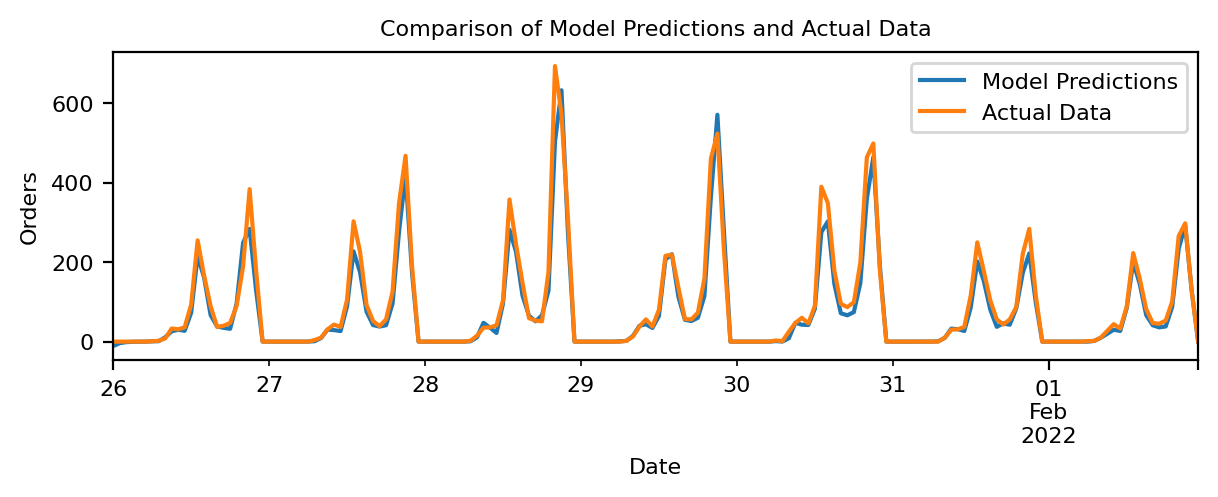

In [57]:
# # Function to inverse log-transform data
# def inverse_log_transform(series):
#     return np.expm1(series)  # This is equivalent to np.exp(series) - 1

# # Transform back the model predictions and the actual orders
# test_df['inverse_model_predictions'] = inverse_log_transform(test_df['model_predictions'])
# test_df['inverse_orders'] = inverse_log_transform(test_df['orders'])

# Plot the predictions and actual orders data
test_df['model_predictions'].plot(legend=True, label='Model Predictions')
test_df['orders'].plot(legend=True, label='Actual Data')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Comparison of Model Predictions and Actual Data')
plt.legend()
plt.show()